In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import RobustScaler

In [3]:
train_url = 'https://raw.githubusercontent.com/lucascheng24/comp4432ML-Dont-over-fit-II/main/train.csv'
test_url = 'https://raw.githubusercontent.com/lucascheng24/comp4432ML-Dont-over-fit-II/main/test.csv'


In [4]:
data=pd.read_csv(train_url)


In [5]:
test = pd.read_csv(test_url)

In [6]:
rs = RobustScaler()
df=data.iloc[:,1:]

In [7]:
df.head()

,target,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [8]:
from torch.utils.data import DataLoader,Dataset
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

C:\Users\lucas\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class Csn(Dataset):
    def __init__(self,train_df):
        self.df=train_df
        
    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data  = self.df.iloc[idx,1:].values
        data = data[11:].reshape(17,17)
        label = self.df.iloc[idx].target
        
        return data,label
        

In [10]:
data = Csn(df)
dataloader = DataLoader(data,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

tensor(1., dtype=torch.float64)


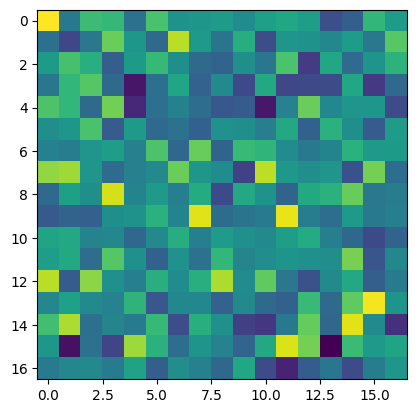

In [11]:
image, label = next(iter(dataloader))
print(label[0])
plt.imshow(image[0,:])

In [12]:
from torch import tensor


tensor(0., dtype=torch.float64)

tensor(0., dtype=torch.float64)

In [13]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1= nn.Conv2d(1,8,5,padding=2)
        self.conv2 = nn.Conv2d(8,16,(3,3),padding = 1)
        self.fc1 = nn.Linear(16*17*17 ,500)
        self.fc2 = nn.Linear(500,1)
        self.dropout = nn.Dropout(0.25)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 16*17*17)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [14]:
model1 = cnn()
model1

cnn(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4624, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [15]:
criterion=nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.003)
epochs= 100

In [16]:
model1=model1.float()

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
x=0
for e in range(epochs):
    run_loss=0
    for image,labels in dataloader:
        optimizer.zero_grad()
        image = image.unsqueeze(1)
        output = model1(image.float())
        labels = labels.unsqueeze(1)
        loss = criterion(output, labels.float())
        loss.backward()
        optimizer.step()
        
        run_loss += loss.item()
    else:
        if x%10==0:
            print(f"Training loss for epoch {x}: {run_loss/len(dataloader)}")
        x=x+1

Training loss for epoch 0: 0.805762636475265
Training loss for epoch 10: 0.23243800178170204
Training loss for epoch 20: 0.09261522250017151
Training loss for epoch 30: 0.0521093484130688
Training loss for epoch 40: 0.029257914386107586
Training loss for epoch 50: 0.026228653921862133
Training loss for epoch 60: 0.02253895805188222
Training loss for epoch 70: 0.018436746038787533
Training loss for epoch 80: 0.013166443262889516
Training loss for epoch 90: 0.010960522447930998


In [19]:
test.head()

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,...,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,...,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,...,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,...,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


In [20]:
class Csn_test(Dataset):
    def __init__(self,train_df):
        self.df=train_df
        
    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data  = self.df.iloc[idx,1:].values
        data = data[11:].reshape(17,17)
        
        return data

In [21]:
data = Csn_test(test)
testloader = DataLoader(data,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)

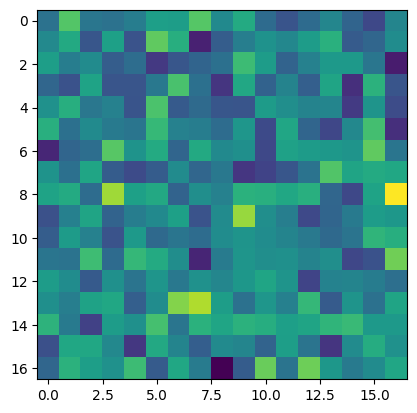

In [22]:
image = next(iter(testloader))
plt.imshow(image[0,:])

In [23]:
lis=[]
model1.eval()
with torch.no_grad():
    for image in testloader:
        image = image.unsqueeze(1)
        output = model1(image.float())
        output = torch.sigmoid(output)
        lis.append(output.numpy())

In [24]:
y_pred_list=lis
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [29]:
# y_pred_list

pred_result_list = y_pred_list

pred_result_list = [int(round(x)) for x in y_pred_list]

In [ ]:
# pred_result_list

In [ ]:
# sub=pd.read_csv('../input/dont-overfit-ii/sample_submission.csv')
# sub['target'] = y_pred_list
# sub.to_csv('submit1.csv', index = False)



In [28]:
import csv


filePath = '../result_folder/CNN_v1.csv'


with open(filePath, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id", "target"])
    for i in range(250, 20000):
        writer.writerow([i, pred_result_list[i-250]])
    file.close()